<a href="https://colab.research.google.com/github/veager/StudyNotes/blob/new/Codes/PyTorch-Tutorial/Pytorch-%E6%A8%A1%E5%9E%8B%E8%AE%AD%E7%BB%83%E7%9A%84%E6%B5%81%E7%A8%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch 模型训练的流程

参考资料

- 博客：Pytorch 模型训练的流程，[地址](https://www.cnblogs.com/veager/articles/16300846.html)

- Github：Codes/PyTorch-Tutorial/Pytorch-模型训练的流程.ipynb

# 0 加载 iris 数据集



In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler

data = load_diabetes()
X = data.data
Y = data.target

# 将输入输出数据归一化到 [0, 1] 之间
scaler_X = MinMaxScaler().fit(X)
scaler_Y = MinMaxScaler().fit(np.expand_dims(Y, axis=1))

Xs = scaler_X.transform(X)
Ys = scaler_Y.transform(np.expand_dims(Y, axis=1))

print(Xs.shape, Ys.shape)
print(Xs[:5], Ys[:5])
print(pd.DataFrame(Xs).describe(), pd.DataFrame(Ys).describe())

# 将数据转换为 tensor 类型 
Xs_tensor = torch.tensor(Xs, dtype=torch.float)
Ys_tensor = torch.tensor(Ys, dtype=torch.float)

(442, 10) (442, 1)
[[0.66666667 1.         0.58264463 0.54929577 0.29411765 0.25697211
  0.20779221 0.28208745 0.56221737 0.43939394]
 [0.48333333 0.         0.14876033 0.35211268 0.42156863 0.30677291
  0.62337662 0.14104372 0.22244301 0.16666667]
 [0.88333333 1.         0.51652893 0.43661972 0.28921569 0.25896414
  0.24675325 0.28208745 0.49658437 0.40909091]
 [0.08333333 0.         0.30165289 0.30985915 0.49509804 0.44721116
  0.23376623 0.42313117 0.57293604 0.46969697]
 [0.51666667 0.         0.20661157 0.54929577 0.46568627 0.41733068
  0.38961039 0.28208745 0.36236911 0.33333333]] [[0.39252336]
 [0.15576324]
 [0.36137072]
 [0.56386293]
 [0.34267913]]
                0           1           2           3           4           5  \
count  442.000000  442.000000  442.000000  442.000000  442.000000  442.000000   
mean     0.491968    0.468326    0.346107    0.459818    0.451668    0.367725   
std      0.218484    0.499561    0.182567    0.194806    0.169647    0.151460   
min      0

## 0.1 全局参数设置

In [3]:
# 样本信息，划分的数据集
N_SAMPLE = Xs_tensor.size()[0]              # 样本总数
N_TRAIN = int(N_SAMPLE * 0.7)               # 训练样本数
N_VALID = int(N_SAMPLE * 0.2)               # 验证样本数
N_TEST = N_SAMPLE - N_TRAIN - N_VALID       # 测试样本数


# 训练过程超参数设置
BATCH_SIZE = 64
N_EPOCH = 100
LEARNING_RATE = 0.5


# 神经网络模型参数
HIDDEN_DIM = 4
INPUT_DIM = Xs_tensor.size()[1]     # sizes of input data and output data
OUTPUT_DIM = Ys_tensor.size()[1]
print("NN Structure:", INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)


# 设置 device，如果 GPU 可用，则使用
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", DEVICE)

NN Structure: 10 4 1
device: cuda:0


# 1 模型构建

# 2 创建结构化数据

- `TensorDataset()` 类

- `Dataset()` 类

- `DataLoader` 类

- `random_split()` 函数



In [4]:
from torch.utils.data import random_split, TensorDataset, Dataset, DataLoader
from torch.utils.data.dataloader import default_collate

# DataSet 类
ds = TensorDataset(Xs_tensor, Ys_tensor)

# split training, validation, testing data
ds_train, ds_valid, ds_test = random_split(ds, lengths=[N_TRAIN, N_VALID, N_TEST])
print(len(ds_train), len(ds_valid), len(ds_test))


# DataLoader of train data, valid data, test data
dl_train = DataLoader(ds_train, batch_size = BATCH_SIZE, shuffle = True,
    collate_fn = lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x))    # 将数据加载到指定的 device 上
    )

dl_valid = DataLoader(ds_valid, batch_size = BATCH_SIZE, # default shuffle = False,
    collate_fn = lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x))
    )

dl_test = DataLoader(ds_test, batch_size = BATCH_SIZE)

309 88 45


# 3. 定义模型 `torch.nn.Module()` 类

In [5]:
# 单隐层 神经网络

class BPNNModeler(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):

        super(BPNNModeler, self).__init__()

        # Layer 1
        self.layer1_linear = nn.Linear(input_dim, hidden_dim)
        self.layer1_sigmoid = nn.Sigmoid()
        # Layer 2
        self.layer2_linear = nn.Linear(hidden_dim, output_dim)
        self.layer2_sigmoid = nn.Sigmoid()
        # Output
        self.layer2_flattern = nn.Flatten(0, -1)
    
    # 正向传播
    def forward(self, x):
        # Layer 1
        out_layer1 = self.layer1_linear(x)
        out_layer1 = self.layer1_sigmoid(out_layer1)
        # Layer 2
        out_layer2 = self.layer2_linear(out_layer1)
        out_layer2 = self.layer2_sigmoid(out_layer2)
        # Output
        out = self.layer2_flattern(out_layer2)
        return out
# ==============================================================================

# 4 定义损失函数

In [6]:
# 定义 损失函数 MSE 损失
def loss_func(model_out, target, reduction='mean'):
    loss = F.mse_loss(model_out, target, reduction=reduction) 
    return loss

# 5 优化器 `torch.optim` 模块

- `torch.optim`

- `torch.optim.lr_scheduler`

In [7]:
# 实例化一个神经网络模型
model = BPNNModeler(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)
model = model.to(DEVICE)

# 定义优化器
optimizer = torch.optim.SGD(
    [{'params': model.parameters(), 
      'initial_lr': LEARNING_RATE}],  # 需要向 param group 传入 initial_lr 参数
    lr = LEARNING_RATE)  # lr 参数不可忽略

# 定义 学习速率调整方式
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# 6 训练过程

In [8]:
logs = {'epoch': [],
        'train_loss': [],
        'valid_loss': [],
        'lr': []}

for epoch in range(N_EPOCH):
    # --------------- 模型训练 ---------------
    train_total_loss = 0.

    model.train()   # 启动模型评估模

    for i, (X_batch, Y_batch) in enumerate(dl_train): 

        optimizer.zero_grad()   # 学习参数的梯度归零

        out = model(X_batch)    # 模型输出
        batch_loss = loss_func(out, Y_batch.flatten(), reduction='mean')  # 返回的 loss 为 一个 batch 的平均损失

        batch_loss.backward()    # 反向传播，计算梯度
        optimizer.step()         # 更新学习参数

        train_total_loss += batch_loss.item()  # total lost 为所有 batch 的平均损失的和，而不是整个训练集的平均损失
    
    logs['epoch'].append(epoch + 1)
    logs['train_loss'].append(train_total_loss)

    # --------------- 模型验证 ---------------
    valid_total_loss = 0. 

    model.eval()   # 启动模型评估模

    with torch.no_grad():  #  取消梯度跟踪
        for X_valid, Y_valid in dl_valid:     

            out = model(X_valid)    # 模型输出
            batch_loss = loss_func(out, Y_valid.flatten())  # 计算 batch loss

            valid_total_loss += batch_loss.item()           # 计算 sum of batch loss
    
    logs['valid_loss'].append(valid_total_loss)

    # --------------- 更新 学习速率 -----------
    scheduler.step() 
    logs['lr'].append(optimizer.param_groups[0]['lr'])

    # Print Traing information
    if (epoch + 1) % 50 == 0:
        print('Epoch: {0:>4}, Train Loss: {1:>10.8f}, Valid Loss: {2:>10.8f}, LR: {3:>10.8f}'.format(
            epoch + 1, 
            train_total_loss,
            valid_total_loss,
            optimizer.param_groups[0]['lr']))

Epoch:   50, Train Loss: 0.29016622, Valid Loss: 0.10878546, LR: 0.00048828
Epoch:  100, Train Loss: 0.29318855, Valid Loss: 0.10878547, LR: 0.00000048


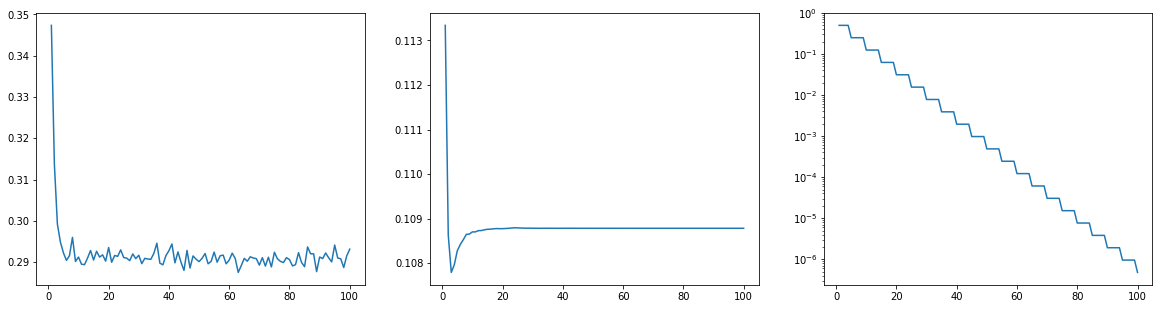

In [9]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(logs['epoch'], logs['train_loss'])
ax2.plot(logs['epoch'], logs['valid_loss'])
ax3.semilogy(logs['epoch'], logs['lr'])

# 7 模型评估

In [10]:
def matric(y_pred, y_true):
    mse = F.mse_loss(y_pred, y_true)
    mae = F.l1_loss(y_pred, y_true)
    ape = torch.abs(y_pred - y_true) / torch.max(torch.abs(y_true) + torch.finfo(torch.float32).eps)
    mape = torch.mean(ape)
    return mse, mae, mape


with torch.no_grad():
    if not (DEVICE.type == "cpu"):
        model.cpu()
    
    train_X, train_Y = ds_train[:N_TRAIN]
    pred_train_Y = model(train_X)
    mse, mae, mape = matric(pred_train_Y, train_Y.flatten())
    print('Train: MSE:{0:>10.4f}; MSE:{1:>10.4f}; MAPE:{2:>10.4f}'.format(
        mse.item(), mae.item(), mape.item()))

    valid_X, valid_Y = ds_valid[:N_VALID]
    pred_valid_Y = model(valid_X)
    mse, mae, mape = matric(pred_valid_Y, valid_Y.flatten())
    print('Valid: MSE:{0:>10.4f}; MSE:{1:>10.4f}; MAPE:{2:>10.4f}'.format(
        mse.item(), mae.item(), mape.item()))

    test_X, test_Y = ds_test[:N_TEST]
    pred_test_Y = model(test_X)
    mse, mae, mape = matric(pred_test_Y, test_Y.flatten())
    print(' Test: MSE:{0:>10.4f}; MSE:{1:>10.4f}; MAPE:{2:>10.4f}'.format(
        mse.item(), mae.item(), mape.item()))

Train: MSE:    0.0582; MSE:    0.2066; MAPE:    0.2066
Valid: MSE:    0.0540; MSE:    0.1966; MAPE:    0.2214
 Test: MSE:    0.0554; MSE:    0.2037; MAPE:    0.2361
